Лабораторна робота №4
Студента СА-43
Мозоля Назарія

Базовий код попердньої лаби

In [1]:
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layers
from tensorflow.keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.metrics import classification_report, confusion_matrix
import itertools
import keras_cv



# Checks for available GPUs and lists them
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Set TensorFlow to use only the first GPU
    tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPU,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)

2024-04-03 20:24:54.897820: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-03 20:24:54.897863: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-03 20:24:54.898934: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-03 20:24:54.905634: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-03 20:24:55.992019: W tensorflow/compiler/tf2

Using TensorFlow backend


In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()


In [3]:
x_train = x_train.astype('float') / 255
x_test = x_test.astype('float') / 255

y_train = tf.one_hot(tf.squeeze(y_train), depth=10)
y_test = tf.one_hot(tf.squeeze(y_test), depth=10)

# y_train = tf.keras.utils.to_categorical(y_train, num_classes=10)
# y_test = tf.keras.utils.to_categorical(y_test, num_classes=10)

In [4]:
id2class = {
    idx: name for idx, name in enumerate([
        'airplane', 'automobile', 'bird',
        'cat', 'deer', 'dog', 'frog',
        'horse', 'ship', 'truck'
    ])
}
print(id2class)

{0: 'airplane', 1: 'automobile', 2: 'bird', 3: 'cat', 4: 'deer', 5: 'dog', 6: 'frog', 7: 'horse', 8: 'ship', 9: 'truck'}


In [5]:
# def display_cifar_images(
#     x: np.ndarray,
#     y: np.ndarray,
#     id2class: dict[int, str],
#     n: int = 4
# ):
#     random_images_indices = np.random.randint(0, x.shape[0], n)
#     images = x[random_images_indices]
#     classes = [id2class[y[idx, 0]] for idx in random_images_indices]


#     f, axs = plt.subplots(1, n, figsize=((3*n, 3)))
#     for image, name, ax in zip(images, classes, axs):
#         ax.imshow(image)
#         ax.axis('off')
#         ax.set(title=f"Class: {name}")
#     plt.show()

In [6]:
# display_cifar_images(x_train, y_train, id2class)

In [7]:
class ConvBlock(tf.keras.Model):
    def __init__(self,filters: int, kernel_size: int, name: str | None = None):
        super().__init__(name=name)
  
        self.conv1 = tf.keras.layers.Conv2D(filters, kernel_size, padding='same')
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.act1 = tf.keras.layers.Activation('relu')
        
  
        self.conv2 = tf.keras.layers.Conv2D(filters, kernel_size, padding='same')
        self.bn2 = tf.keras.layers.BatchNormalization()
        self.act2 = tf.keras.layers.Activation('relu')

        
        self.dense3=tf.keras.layers.MaxPooling2D(pool_size=(2,2),strides=(1,1),padding='valid')

    def call(self, inputs, training: bool):
        x = self.conv1(inputs)
        x = self.bn1(x, training=training) 
        x = self.act1(x)
        
        x = self.conv2(x)
        x = self.bn2(x, training=training)  
        x = self.act2(x)
        return x


In [8]:
class ClassificationHead(tf.keras.Model):
    def __init__(self, hidden_dim: int, n_classes: int, dropout_rate: float, *args, **kwargs):
        super(ClassificationHead, self).__init__(*args, **kwargs)


        self.flatten = tf.keras.layers.Flatten()
        self.dense1 = tf.keras.layers.Dense(units=hidden_dim, activation='relu')
        self.dropout1 = tf.keras.layers.Dropout(dropout_rate)
        self.dense2 = tf.keras.layers.Dense(units=hidden_dim/2, activation='relu')
        # self.dropout2 = tf.keras.layers.Dropout(dropout_rate)
        self.dense3 = tf.keras.layers.Dense(units=hidden_dim/4, activation='relu')
        # self.dropout3 = tf.keras.layers.Dropout(dropout_rate)
        self.out = tf.keras.layers.Dense(n_classes,activation='softmax')

    def call(self, inputs, training: bool):
        x = self.flatten(inputs)
        x = self.dense1(x)
        x = self.dropout1(x, training=training)
        x = self.dense2(x)
        # x = self.dropout2(x, training=training)
        x = self.dense3(x)
        # x = self.dropout3(x, training=training)
        return self.out(x)



In [9]:
class Cifar10Classifier(tf.keras.Model):
    def __init__(self, hidden_dim:int, n_classes:int, dropout_rate:float , name: str | None = None):
        super().__init__(name=name)



        self.feature_extractor = tf.keras.Sequential(
                [
                     
                    # keras_cv.layers.RandAugment(value_range=(0, 1), 
                    #                 augmentations_per_image=1, 
                    #                 magnitude=0.1),  
                    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
                    tf.keras.layers.RandomRotation(0.2),
                    tf.keras.layers.RandomZoom((0.1, 0.2)),
                    ConvBlock(16, 5),
                    ConvBlock(64, 3),
                    # ConvBlock(128, 1),


                ],
            name='feature_extractor'
        )

        self.pool=tf.keras.layers.GlobalMaxPooling2D()
        self.head = ClassificationHead(hidden_dim, n_classes,dropout_rate, name='head')

    def call(self, inputs, training: bool):
        x = self.feature_extractor(inputs)
        x = self.pool(x)
        x = self.head(x)
        return x


In [10]:
model = Cifar10Classifier(hidden_dim=100,n_classes=len(id2class),dropout_rate=0.1)
model.get_layer('feature_extractor')

In [11]:
model.compile(
    optimizer=tf.keras.optimizers.AdamW(learning_rate=3e-4,weight_decay=1e-4),
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False,label_smoothing=0.1),
    # loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy'],
    run_eagerly=True
)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [12]:
hist=[]

In [13]:
hist.append(model.fit(
    x=x_train,
    y=y_train,
    epochs=150,
    batch_size=64,
    validation_data=(x_test, y_test),
   # callbacks=[early_stopping]
))


Epoch 1/150
782/782 [==============================] - 181s 231ms/step - loss: 2.0454 - accuracy: 0.2620 - val_loss: 1.8965 - val_accuracy: 0.3422
Epoch 2/150
782/782 [==============================] - 181s 232ms/step - loss: 1.8972 - accuracy: 0.3392 - val_loss: 1.8384 - val_accuracy: 0.3708
Epoch 3/150
782/782 [==============================] - 183s 234ms/step - loss: 1.8314 - accuracy: 0.3800 - val_loss: 1.8430 - val_accuracy: 0.3762
Epoch 4/150
782/782 [==============================] - 182s 232ms/step - loss: 1.7766 - accuracy: 0.4074 - val_loss: 1.7171 - val_accuracy: 0.4386
Epoch 5/150
782/782 [==============================] - 184s 236ms/step - loss: 1.7453 - accuracy: 0.4243 - val_loss: 1.8444 - val_accuracy: 0.3840
Epoch 6/150
782/782 [==============================] - 186s 238ms/step - loss: 1.7219 - accuracy: 0.4357 - val_loss: 1.7726 - val_accuracy: 0.3898
Epoch 7/150
782/782 [==============================] - 189s 242ms/step - loss: 1.6998 - accuracy: 0.4474 - val_loss: 1

In [14]:
hist.append(model.fit(
    x=x_train,
    y=y_train,
    epochs=150,
    batch_size=64,
    validation_data=(x_test, y_test),
    callbacks=[early_stopping]
))

Epoch 1/150
782/782 [==============================] - 188s 241ms/step - loss: 1.3408 - accuracy: 0.6199 - val_loss: 1.5079 - val_accuracy: 0.5485
Epoch 2/150
782/782 [==============================] - 188s 240ms/step - loss: 1.3404 - accuracy: 0.6174 - val_loss: 1.5115 - val_accuracy: 0.5499
Epoch 3/150
782/782 [==============================] - 188s 240ms/step - loss: 1.3392 - accuracy: 0.6195 - val_loss: 1.4822 - val_accuracy: 0.5606
Epoch 4/150
782/782 [==============================] - 190s 243ms/step - loss: 1.3358 - accuracy: 0.6221 - val_loss: 1.5529 - val_accuracy: 0.5386
Epoch 5/150
782/782 [==============================] - 190s 243ms/step - loss: 1.3358 - accuracy: 0.6218 - val_loss: 1.4614 - val_accuracy: 0.5696
Epoch 6/150
782/782 [==============================] - 190s 243ms/step - loss: 1.3366 - accuracy: 0.6206 - val_loss: 1.5549 - val_accuracy: 0.5393
Epoch 7/150
782/782 [==============================] - 189s 242ms/step - loss: 1.3334 - accuracy: 0.6245 - val_loss: 1

In [15]:
model.summary()

Model: "cifar10_classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extractor (Sequent  (None, 32, 32, 64)        54480     
 ial)                                                            
                                                                 
 global_max_pooling2d (Glob  multiple                  0         
 alMaxPooling2D)                                                 
                                                                 
 head (ClassificationHead)   multiple                  13085     
                                                                 
Total params: 67565 (263.93 KB)
Trainable params: 67245 (262.68 KB)
Non-trainable params: 320 (1.25 KB)
_________________________________________________________________


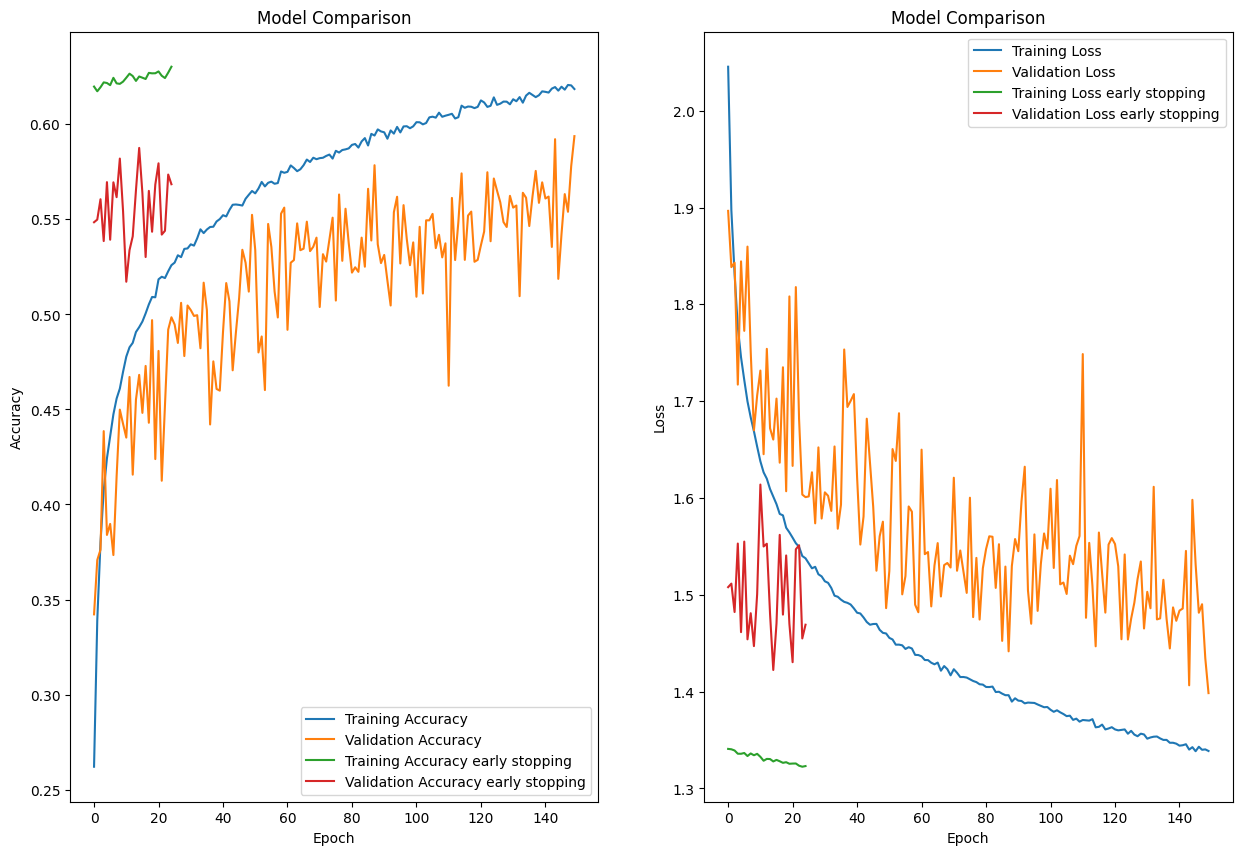

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(15, 10))
axes = axes.flatten()




ax = axes[0]

# Plot training and validation accuracy for the current pair
ax.plot(hist[0].history['accuracy'], label=f'Training Accuracy')
ax.plot(hist[0].history['val_accuracy'], label=f'Validation Accuracy')

ax.plot(hist[1].history['accuracy'], label=f'Training Accuracy early stopping')
ax.plot(hist[1].history['val_accuracy'], label=f'Validation Accuracy early stopping')

ax.set_title(f'Model Comparison')
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.legend()






ax = axes[1]

# Plot training and validation accuracy for the current pair
ax.plot(hist[0].history['loss'], label=f'Training Loss')
ax.plot(hist[0].history['val_loss'], label=f'Validation Loss')

ax.plot(hist[1].history['loss'], label=f'Training Loss early stopping')
ax.plot(hist[1].history['val_loss'], label=f'Validation Loss early stopping')

ax.set_title(f'Model Comparison')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend()




# # Set the same x- and y-axis scale for all plots
# ax.set_ylim([0, 1])
# ax.set_xlim([0, 150])

In [28]:
predictions1 = model.predict(x_test)
predicted_classes1 = np.argmax(predictions1, axis=1)
predicted_classes1 = tf.one_hot(tf.squeeze(predicted_classes1), depth=10)

313/313 [==============================] - 7s 21ms/step


In [22]:
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    Ця функція друкує та візуалізує матрицю невідповідностей з кольорами.
    `cm`: матриця невідповідностей
    `classes`: список назв класів для відображення на осях
    `title`: заголовок для матриці
    `cmap`: колірна схема для візуалізації
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    # Вивід значень у квадратах
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


бо ми робили one-hot -encoding

In [33]:
y_test = tf.argmax(y_test, axis=1)
predicted_classes1 = np.argmax(predicted_classes1, axis=1)

In [35]:
predicted_classes1

array([9, 8, 9, ..., 3, 1, 7])

Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.67      0.65      1000
           1       0.58      0.80      0.67      1000
           2       0.61      0.32      0.42      1000
           3       0.54      0.34      0.41      1000
           4       0.65      0.36      0.47      1000
           5       0.67      0.54      0.60      1000
           6       0.50      0.84      0.63      1000
           7       0.53      0.67      0.60      1000
           8       0.76      0.64      0.69      1000
           9       0.55      0.70      0.62      1000

    accuracy                           0.59     10000
   macro avg       0.60      0.59      0.57     10000
weighted avg       0.60      0.59      0.57     10000

Confusion Matrix:


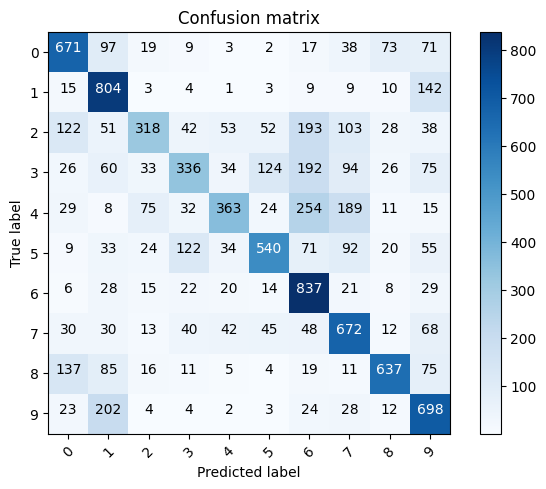

In [36]:
cr1 = classification_report(y_test, predicted_classes1)
print("Classification Report:")
print(cr1)

cm1 = confusion_matrix(y_test, predicted_classes1)
print("Confusion Matrix:")
plot_confusion_matrix(cm1, id2class.keys())

In [37]:
# model.save('./DeepL/lab4')

INFO:tensorflow:Assets written to: ./DeepL/lab4/assets


INFO:tensorflow:Assets written to: ./DeepL/lab4/assets
